## Initial results and definition of the model:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.pipeline import make_pipeline

from plot_helper import plt_inv
import readLHE
import invariants

The first DCGAN models had stability problems. In particular, I encountered *mode collapse* and *convergence failure* checked through the plots of the Generator and Discriminator **loss functions**.

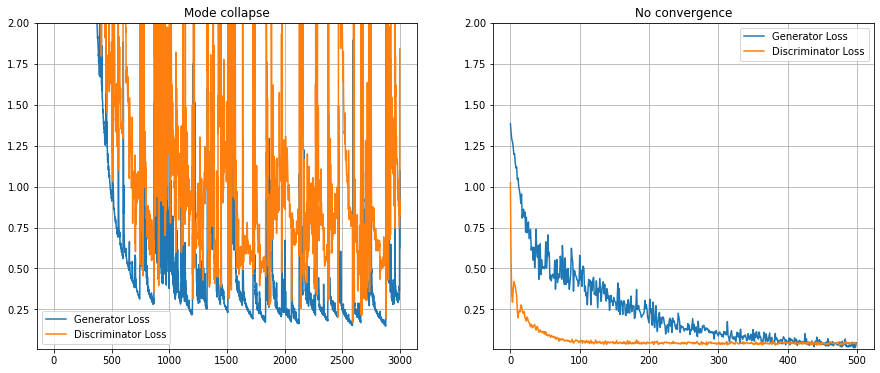

In [2]:
#failures
titles = ['Mode collapse', 'No convergence']
files = glob.glob('failures/loss*.txt')
labels = ['Generator Loss', 'Generator Loss', 'Discriminator Loss', 'Discriminator Loss']
losses = [np.loadtxt(files[i]) for i in range(len(files))]
fig, ax = plt.subplots(1,2, figsize=(15,6))
for i in range(len(files)):
    ax[i%2].plot(losses[i][:3000], label=labels[(i)])
    ax[i%2].set_ylim(0.01, 2.0)
    ax[i%2].set_title(titles[i%2])
    ax[i%2].grid(True)
    ax[i%2].legend()

### Model architecture

The final stable DCGAN model found has ~100k parameters and simulates a 10x10 image encoding with a decreasing number of filters.

In [3]:
#load models
generator = tf.keras.models.load_model('models/generator.h5', compile=False)
discriminator = tf.keras.models.load_model('models/discriminator.h5')

In [4]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Input (Dense)          (None, 200)               20200     
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 200)               800       
_________________________________________________________________
Leaky_ReLU_1 (LeakyReLU)     (None, 200)               0         
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, 2)         0         
_________________________________________________________________
TConv_1 (Conv2DTranspose)    (None, 10, 10, 128)       2304      
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 10, 10, 128)       512       
_________________________________________________________________
Leaky_ReLU_2 (LeakyReLU)     (None, 10, 10, 128)       0

In [5]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Input (Dense)          (None, 200)               600       
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 10, 2)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 10, 10, 128)       2432      
_________________________________________________________________
Leaky_ReLU_1 (LeakyReLU)     (None, 10, 10, 128)       0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 10, 10, 64)        73792     
_________________________________________________________________
Leaky_ReLU_2 (LeakyReLU)     (None, 10, 10, 64)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 10, 10, 32)       

### Preliminary check
To check the correct learning behavior of the neural network, a first example training has been done on a triple Gaussian toy distribution. The results show that the network correctly learns the mean and the variance of the distributions and that the KL-div improves with increasing epochs

<img src="hist_epoch_30000.png">
<img src="hist_epoch_200000.png">

### Features reconstruction

#### Loss functions
The first training has been done using the **Adam** optimizer with MinMax preprocessing. The loss functions showed an unstable trend with eriodical spikes that worsened the results. These are also shown in the accuracy of the discriminator

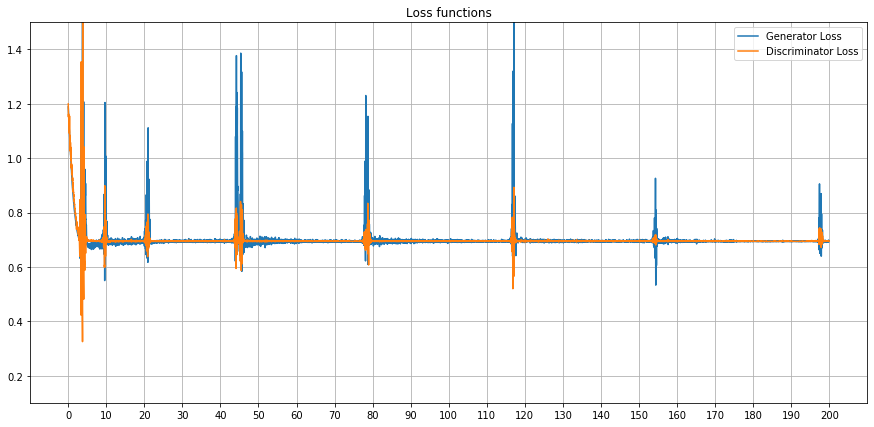

In [6]:
#losses
iter = 100
epochs = 200
d_loss = np.loadtxt('failures/d_loss_adam.txt')
g_loss = np.loadtxt('failures/g_loss_adam.txt')

plt.figure(figsize=(15,7))
plt.title('Loss functions')
plt.plot(g_loss, label='Generator Loss')
plt.plot(d_loss, label='Discriminator Loss')
plt.xticks(np.arange(0, len(d_loss)+1, 10*iter), np.arange(0, epochs+1, 10))
plt.ylim(0.1, 1.5)
plt.legend()
plt.grid(True)
plt.show()

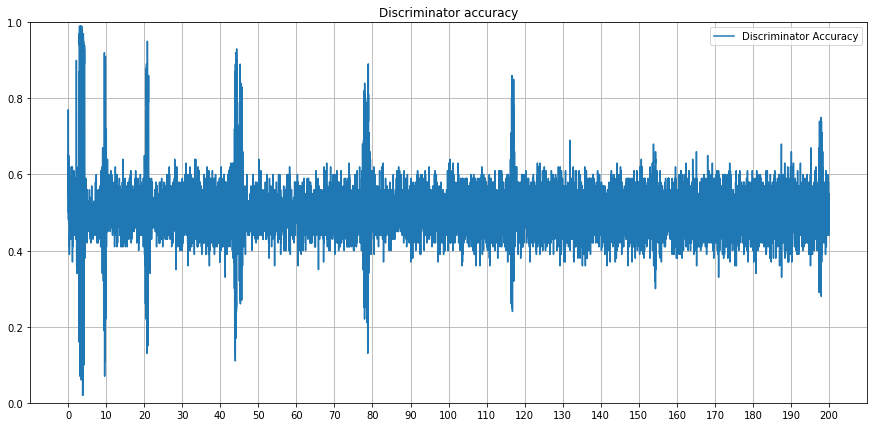

In [7]:
#discriminator accuracy
iter = 100
epochs = 200
d_acc = np.loadtxt('failures/d_acc_adam.txt')

plt.figure(figsize=(15,7))
plt.title('Discriminator accuracy')
plt.plot(d_acc, label='Discriminator Accuracy')
plt.xticks(np.arange(0, len(d_loss)+1, 10*iter), np.arange(0, epochs+1, 10))
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

#### Input features

In [8]:
file = '../../samples/ppttbar_10k_events.lhe'
evs = readLHE.readEvent(file)
init = readLHE.readInit(file)
invar = np.zeros((readLHE.NEvents(file),3))
i = 0
for ev in evs:
    invar[i,0] = invariants.GetEnergySquared(ev)
    invar[i,1] = invariants.GetMandelT(ev)
    invar[i,2] = invariants.GetRapidity(init, ev)
    i += 1

mM_scal = MinMaxScaler((-1,1))
mM_scal.fit(invar)

pred = np.loadtxt('failures/pred_adam.txt')
pred = mM_scal.inverse_transform(pred)

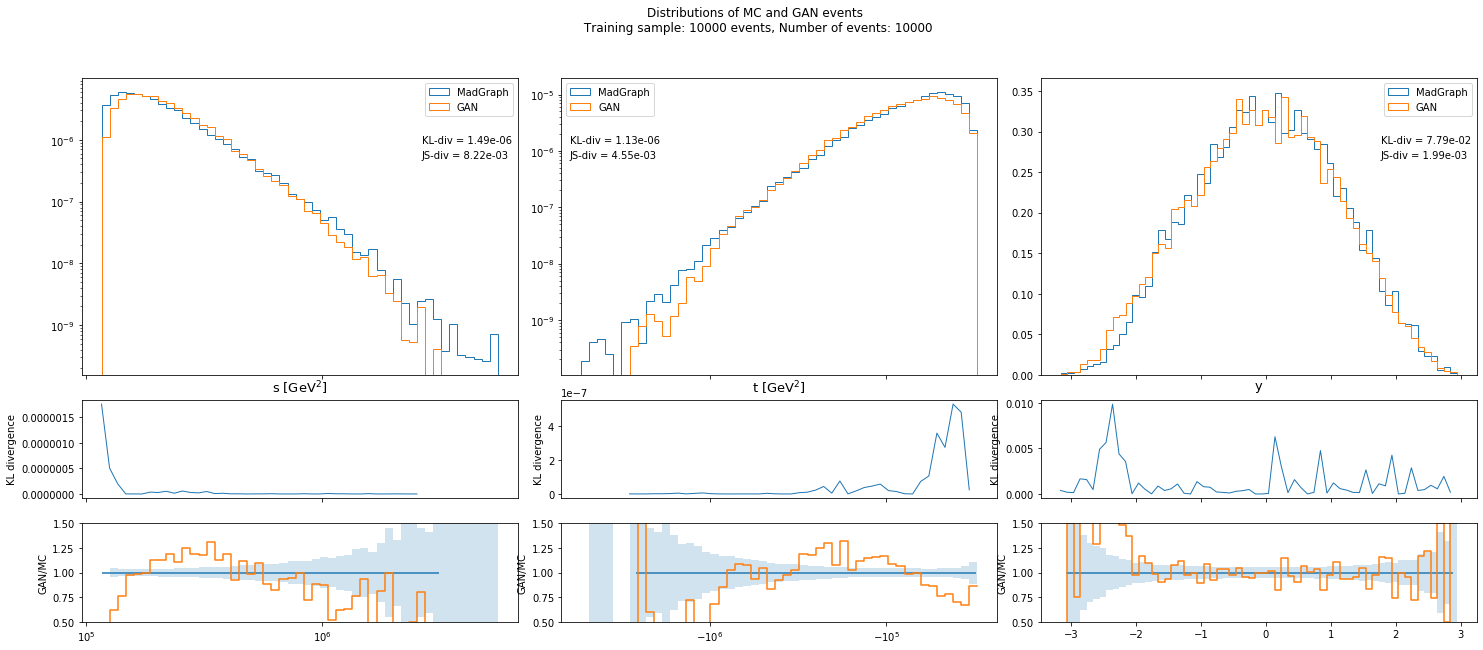

In [9]:
plt_inv(invar, pred, len(invar))

### SGD optimizer
In order to remove the spikes in the learning procedure, I used the standard **SGD** optimizer. In this case the spikes are missing and the initial results are good.
#### StandardScaler
To check the effects of a different preprocessing a StandardScaler has beeen used. The consequence of having an unlimited range is that a small fraction of events appear over the training sample range (~1%).

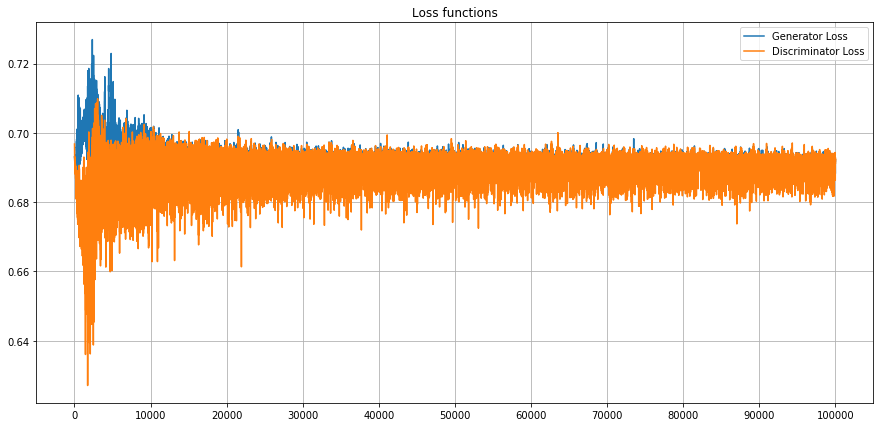

In [10]:
#losses
iter = 1
epochs = 200000
d_loss, _ = np.loadtxt('sgd/d_loss_std.txt', unpack=True)
g_loss, _ = np.loadtxt('sgd/g_loss_std.txt', unpack=True)

plt.figure(figsize=(15,7))
plt.title('Loss functions')
plt.plot(g_loss, label='Generator Loss')
plt.plot(d_loss, label='Discriminator Loss')
plt.xticks(np.arange(0, len(d_loss)+1, 10000*iter), np.arange(0, epochs+1, 10000))
#plt.ylim(0.1, 1.5)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [10]:
file = '../../samples/ppttbar_500k_events.lhe'
evs = readLHE.readEvent(file)
init = readLHE.readInit(file)
invar_sgd = np.zeros((readLHE.NEvents(file),3))
i = 0
for ev in evs:
    invar_sgd[i,0] = invariants.GetEnergySquared(ev)
    invar_sgd[i,1] = invariants.GetMandelT(ev)
    invar_sgd[i,2] = invariants.GetRapidity(init, ev)
    i += 1

std_scal = StandardScaler()
std_scal.fit(invar_sgd)

pred_std = np.loadtxt('sgd/pred_std.txt')
pred_std = std_scal.inverse_transform(pred_std)

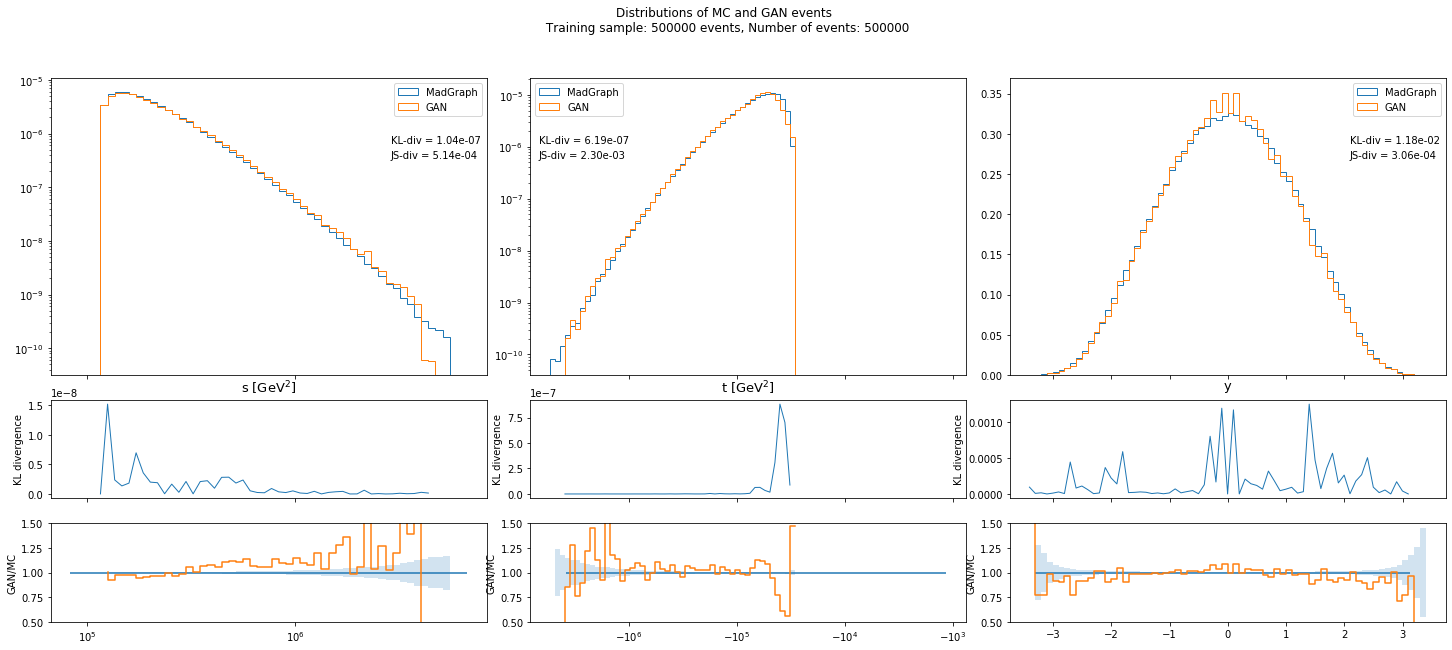

In [11]:
plt_inv(invar_sgd, pred_std, len(invar_sgd))

In [12]:
# number of events over the maximum of invar_sgd for the t invariant
print(len(pred_std[:,1][pred_std[:,1]>max(invar_sgd[:,1])]))
# number of events below the minimum of invar_sgd for the s invariant
print(len(pred_std[:,0][pred_std[:,0]<min(invar_sgd[:,0])]))

270
927


A major issue encountered is the correct reproduction of the kinematic constraints, e.g. the Mandelstam variables relationship **s+t+u = 0**. More generally, the correlations between the input features has to be further studied.

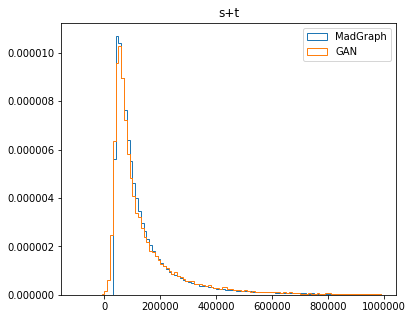

In [13]:
st_dts = np.delete(invar_sgd, 2, axis=1)
st_gen = np.delete(pred_std, 2, axis=1)
plt.figure(figsize=(6,5))
plt.hist(np.sum(st_dts, axis=1),bins=np.arange(-1e5,1e6, 1e4), histtype='step', label='MadGraph', density=True)
plt.hist(np.sum(st_gen, axis=1),bins=np.arange(-1e5,1e6, 1e4), histtype='step', label='GAN', density=True)
plt.title('s+t')
plt.legend()
plt.show()

#### MinMaxScaler + Yeo-Johnson PowerTransformer
The main difficulty of the network consists in dealing with extremely peaked distributions and long tails, thus generating a space difficult to reproduce by the weights. A possible solution is to transform the input features in a *more* Gaussian looking ones. In this training, the preprocessing is a **PowerTransformer** followed by a **MinMaxScaler**. 

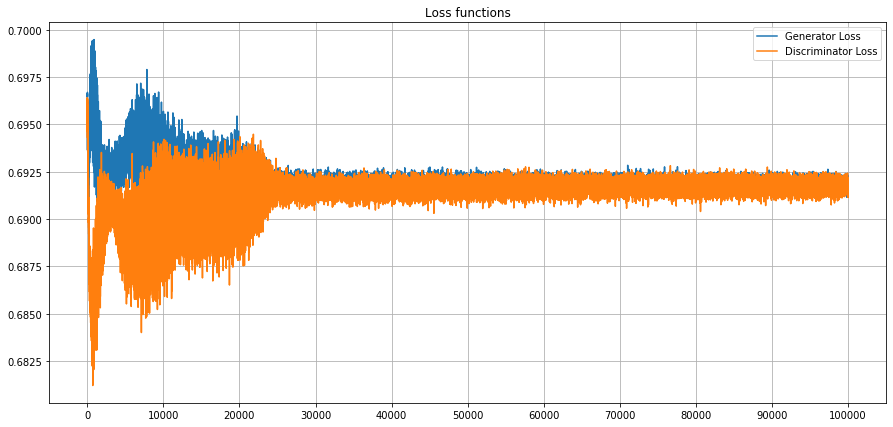

In [14]:
#losses
iter = 1
epochs = 200000
d_loss, _ = np.loadtxt('sgd/d_loss_pt.txt', unpack=True)
g_loss, _ = np.loadtxt('sgd/g_loss_pt.txt', unpack=True)

plt.figure(figsize=(15,7))
plt.title('Loss functions')
plt.plot(g_loss, label='Generator Loss')
plt.plot(d_loss, label='Discriminator Loss')
plt.xticks(np.arange(0, len(d_loss)+1, 10000*iter), np.arange(0, epochs+1, 10000))
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [15]:
pipeline = make_pipeline(PowerTransformer(standardize=True), MinMaxScaler((-1,1)))
pipeline.fit(invar_sgd)

pred_pt = np.loadtxt('sgd/pred_pt.txt')
pred_pt = pipeline.inverse_transform(pred_pt)

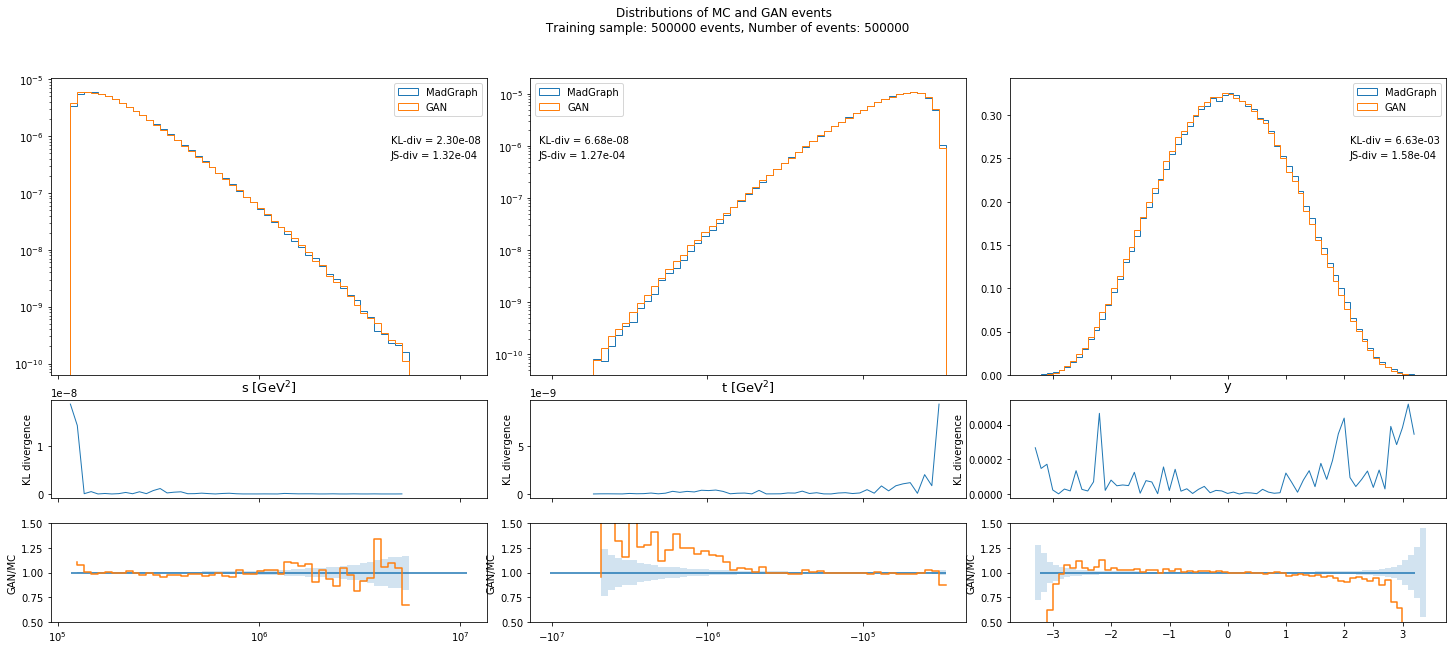

In [16]:
plt_inv(invar_sgd, pred_pt, len(invar_sgd))

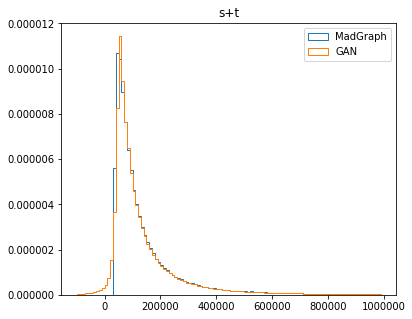

In [17]:
st_dts = np.delete(invar_sgd, 2, axis=1)
st_gen = np.delete(pred_pt, 2, axis=1)
plt.figure(figsize=(6,5))
plt.hist(np.sum(st_dts, axis=1),bins=np.arange(-1e5,1e6, 1e4), histtype='step', label='MadGraph', density=True)
plt.hist(np.sum(st_gen, axis=1),bins=np.arange(-1e5,1e6, 1e4), histtype='step', label='GAN', density=True)
plt.title('s+t')
plt.legend()
plt.show()

Also in this case the **s+t** constraint is not well reproduced. However, these results are still obtained with the basic SGD optimizer and a better performance is expected with more advanced ones. Thus, the next step is to run an **hyperoptimization** on the principal training parameters to find the best minimum of the latent space. 